### Modeling with features complete.csv and tests_latest_state_level.csv which contains Date,Name of State / UT,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated and coronaenquirycalls,cumulativepeopleinquarantine,negative,numcallsstatehelpline,numicubeds,numisolationbeds,numventilators,populationncp2019projection,positive,source1,source2,state,tagpeopleinquarantine,tagtotaltested,testpositivityrate,testspermillion,testsperpositivecase,testsperthousand,totaln95masks,totalpeoplecurrentlyinquarantine,totalpeoplereleasedfromquarantine,totalppe,totaltested,unconfirmed,updatedon,_d415a


Merge these 2 files at a state level with common key as Date. The merging is already been done in tseries_analysis_full_singlestep_forecats

The code uses snippets from machine learning mastery for building the main blocks of deep learning models. https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/ 

In [71]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import csv
import sys
import matplotlib.pyplot as plt
from sklearn import preprocessing
import mplcursors
import datetime
from pmdarima.arima import auto_arima
from fbprophet import Prophet
import statsmodels.api as sm
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from tslearn.svm import TimeSeriesSVR
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
from numpy import array
from math import sqrt
from numpy import split

startDate ='2020-01-30'
endDate = '2020-06-05'

### TensorFlow related Imports

In [72]:
from tensorflow.python.keras.layers import Dense, LSTM, RepeatVector
from tensorflow.python.keras import Sequential 

from tensorflow.python.keras.layers import TimeDistributed,Flatten, Bidirectional
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling1D
from tensorflow.python.keras.layers.convolutional_recurrent import ConvLSTM2D

### Change it to LSTM/CNN/LSTM_CNN/CONV2_LSTM based on which model you want to train

In [113]:
ModelType ='CONV2_LSTM' 

### Function to find the number closest  to input train datasizee of  and divisible by 7 (number of days in a week)


In [114]:
def closest_day(n, m):
    # Find the quotient
    q = int(n / m)

    n1 = m * q

    if ((n * m) > 0):
        n2 = (m * (q + 1))
    else:
        n2 = (m * (q - 1))

    if (abs(n - n1) < abs(n - n2)):
        return n1

    return n2

### Split multivariate dataset into train/test sets into Steps/Sequence of 7 days which are nothing but composed of each week's data

We set no_of_days =7 , which helps to determine how the train-test dataset can be formed from the entire set 

In [115]:
def split_dataset(data):

    split_factor = int((np.shape(data)[0]*0.7))

    no_of_days = 7
    trn_close_no = closest_day(split_factor, no_of_days)
    te_close_no = closest_day((np.shape(data)[0]-split_factor), no_of_days)

    train, test = data[0:trn_close_no], data[trn_close_no:(trn_close_no + te_close_no)]

    len_train = np.shape(train)[0]
    len_test = np.shape(test)[0]

    train = array(split(train[0:len_train], len(train[0:len_train]) / 7))
    test = array(split(test, len(test) / 7))

    return train, test



### Evaluation of weekly forecast by comparing it against expected value for each day to determine RMSE

In [116]:
def evaluate_forecasts(actual, predicted):

    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])       
        rmse = sqrt(mse)
        # store in a list
        scores.append(rmse)

        plt.figure(figsize=(14, 12))
        plt.plot(actual[:, i], label='actual')
        plt.plot(predicted[:, i], label='predicted') 
        plt.title(ModelType + ' based Multi-Step Time Series Active Cases Prediction for step ' + str(i)) 
        plt.legend()
        plt.show()

    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

### Summarize and Print Scores based on each type of Model

In [117]:
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

### The historic data is converted into inputs and outputs i.e. the input features and the predicted outcome.

The data is first flattened to incorporate all input features as its multi-variate and then spllit into sequences (first sequence of 7 days, next sequence of 8 days and the next sequence of 9 days) In this way every week takes into consideration historic data in addition to predicted outcome from previous week

In [118]:
def to_supervised(train, n_input, n_out=7):
    
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # Iterate over the entire history one time step/time
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out

        #check for suffcient data size
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        in_start += 1
    return array(X), array(y)

### Train CNN moel with Adam optimizer , with 200 epocs and batch size of 4. 

As data size is very small we have to limit the batch size =4 . We use Keras's APIs (Sequential) with  to create the model with 2 Dense Layers wih the first layer composed of 10 units 

In [119]:
def build_model_cnn(train, n_input):
    
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    
    verbose, epochs, batch_size = 0, 200, 4
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
   
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
   
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

### Train LSTM moel with Adam optimizer , 50  epocs and batch size of 16. 

The output is rehshaped to [samples, timesteps, features]

In [120]:
def build_model_lstm(train, n_input):
    
    # prepare data
    train_x, train_y = to_supervised(train, n_input)

    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

The output is rehshaped to [samples, timesteps, features] and the model created with stacked layers of Bi-Directional LSTM and then its wrapped with TimeDistributed layer

### Train Bi-Directionsl LSTM moel with Adam optimizer , 50  epocs and batch size of 16. 

In [121]:
def build_model_bi_lstm(train, n_input):
    
    train_x, train_y = to_supervised(train, n_input)
    
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

    model = Sequential()
    model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))))
    model.add(RepeatVector(n_outputs))
    model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=True)))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

### Train Stacked LSTM with CNN model with Adam optimizer , 500  epocs and batch size of 16. 

We have used Conv1D (1D Convolution Layer) with 64 filters and kernel size of 3. The CNN outout is fed to LSTM (with 200 neuron units)

In [122]:
def build_model_cnn_lstm(train, n_input):
    train_x, train_y = to_supervised(train, n_input)
    
    verbose, epochs, batch_size = 0, 500, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')

    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

### Forecasting for Each type of Model

The input data is reshaped into  [1, n_input, n] for prediction with multiple features as input. The forecast is done for the next week

In [123]:
def forecast(model, history, n_input):
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    if(ModelType == 'LSTM'):
           input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    if(ModelType == 'BI_LSTM'):
           input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    elif(ModelType == 'CNN'):
           input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    elif(ModelType == 'LSTM_CNN'):
           input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
   
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat

### Each Deep Learning Model is evaluated based on list of weekly data and then the predictions are appened to history which can be used for prediction for future data. The predicted data is then evaluated to determine its metrics

In [124]:
def evaluate_model(train, test, n_input):
    model = None
    if(ModelType == 'LSTM'):
        model = build_model_lstm(train, n_input)
    elif(ModelType == 'BI_LSTM'):
        model = build_model_bi_lstm(train, n_input)
    elif(ModelType == 'CNN'):
        model = build_model_cnn(train, n_input)
    elif(ModelType == 'LSTM_CNN'):
        model = build_model_cnn_lstm(train, n_input)
        
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        yhat_sequence = forecast(model, history, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i, :])

    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, test[:, :, 0], predictions

### Listing All Indian States which have data preprocessed that can be used for Evaluation

In [125]:
unique_states = ['Andaman and Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh',
 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh',
 'Dadra and Nagar Haveli and Daman and Diu', 'Delhi', 'Goa', 'Gujarat',
 'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir', 'Jharkhand', 'Karnataka',
 'Kerala', 'Ladakh', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya',
 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim',
 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand',
 'West Bengal']

We will use the processed data done for Single Step Time Series Forecasting using LSTM, CNN , CNN+LSTM , CONV2LSTM . Delhi's index is 8 from the list of Unique states

# Multi Step LSTM based Prediction for State Delhi

Here we read data for all states and select the data for Delhi

Start date is  2020-03-25
End Date is  2020-06-05
Actual Results (3, 7)
Predicted  Results (3, 7, 1)


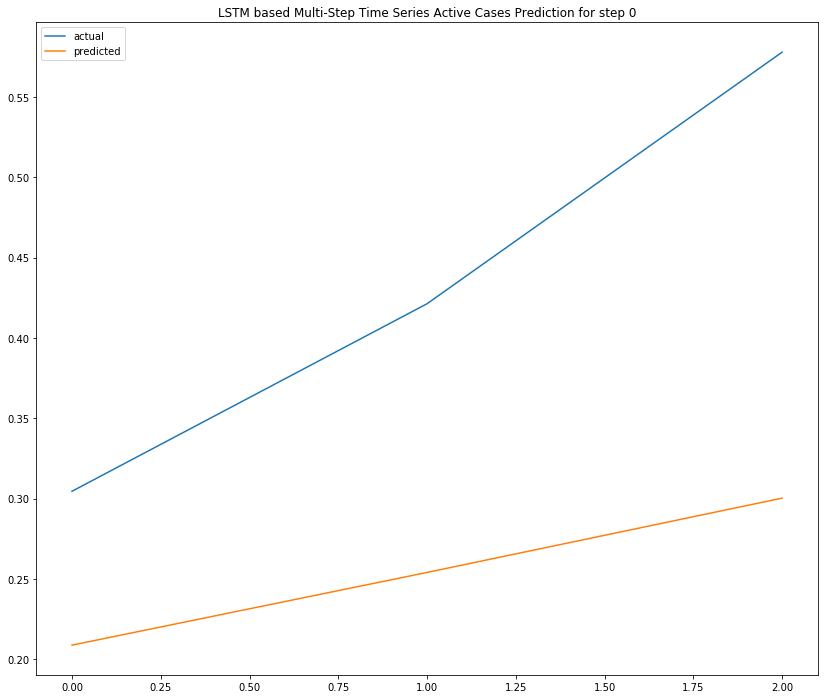

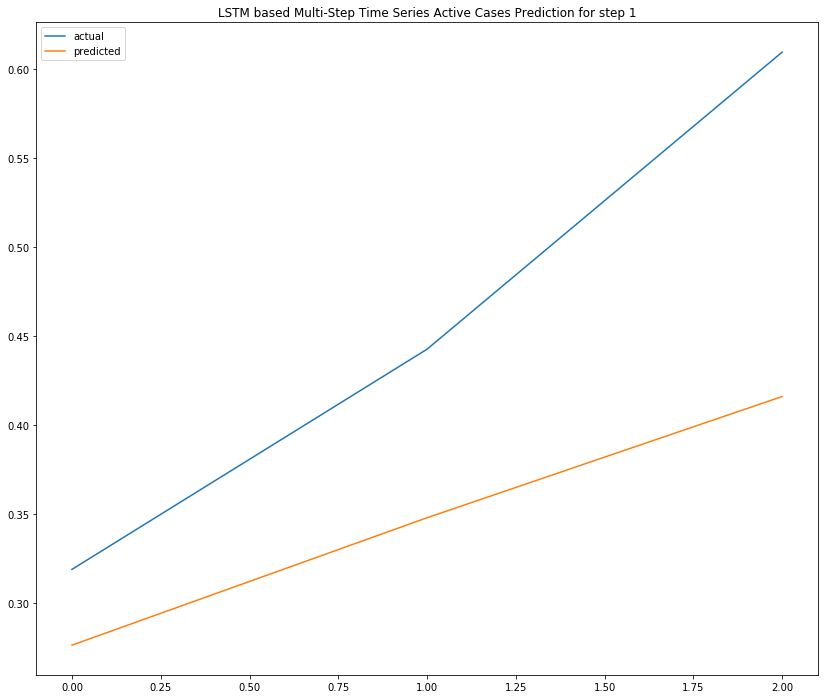

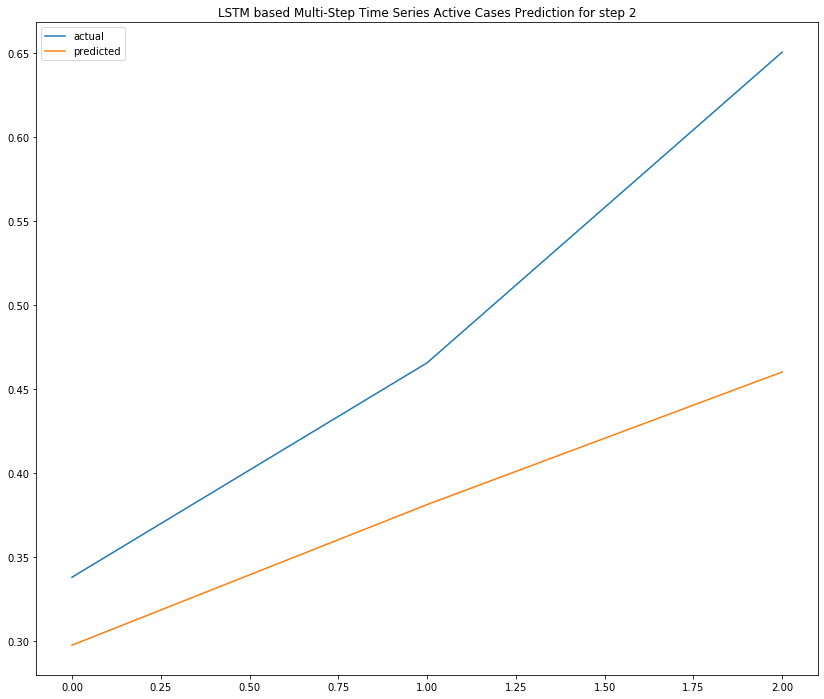

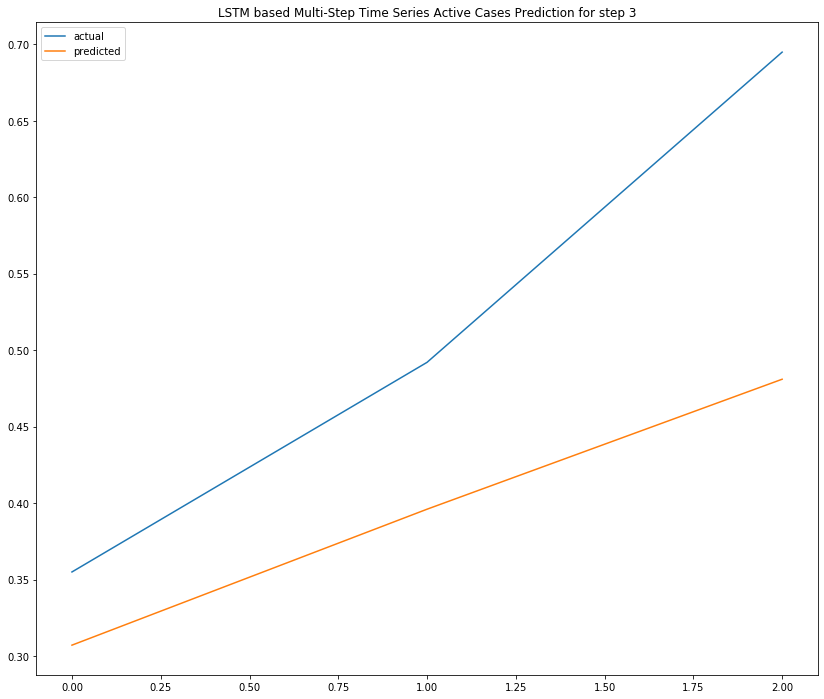

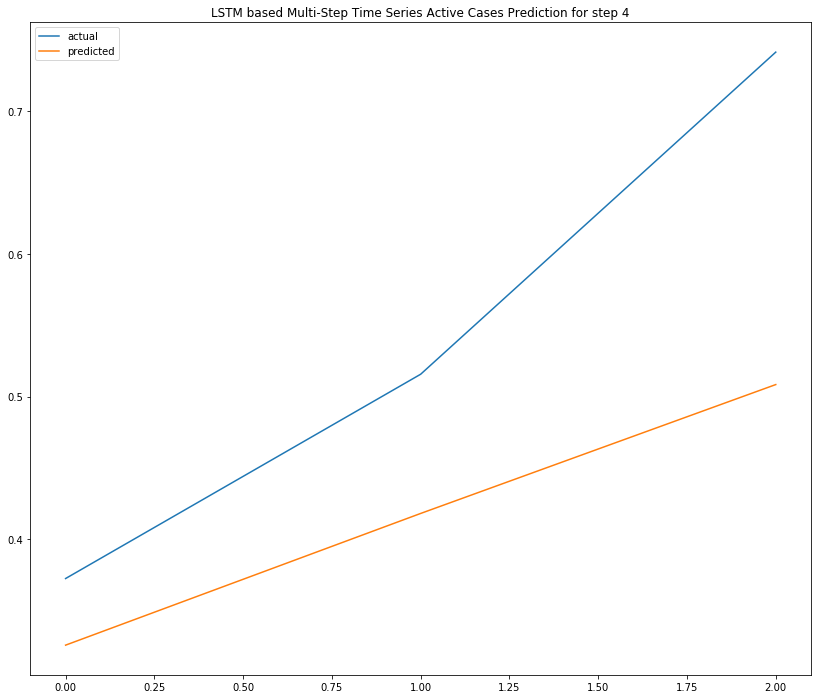

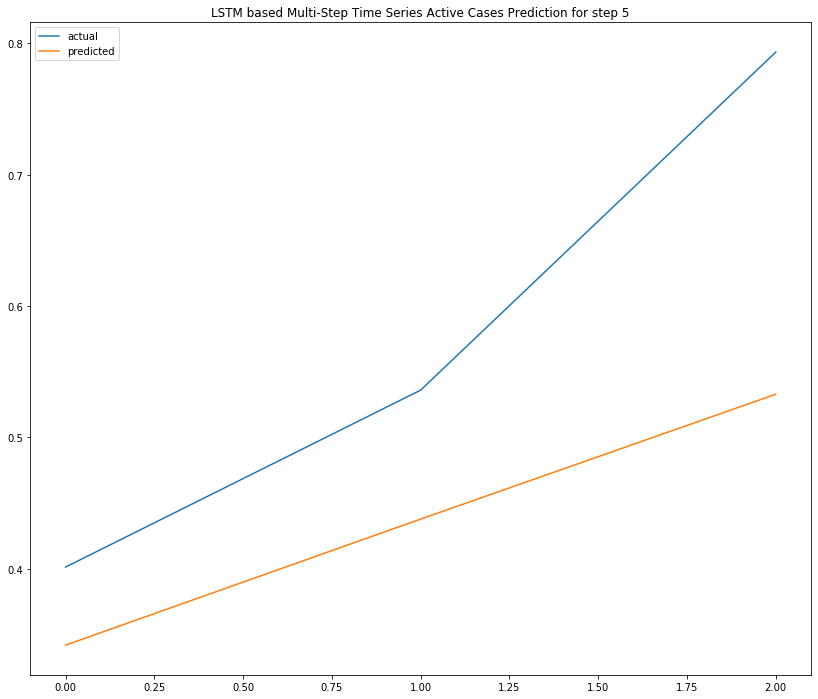

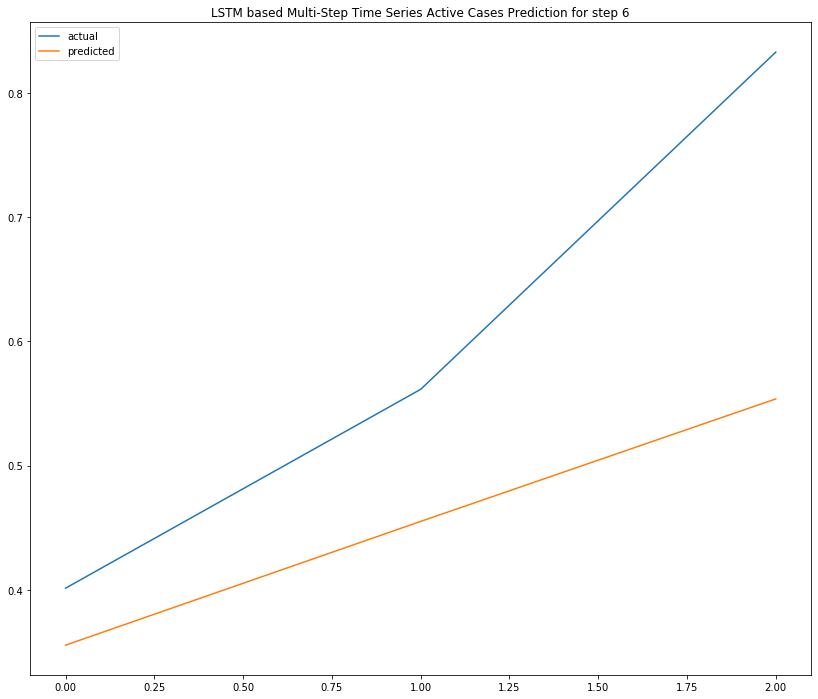

LSTM: [0.155] 0.2, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2


In [53]:
df_state_all = pd.read_csv('all_states/all.csv')
df_state_all = df_state_all.drop(columns=['Latitude', 'Longitude', 'index'])
stateName = unique_states[8]

dataset = df_state_all[df_state_all['Name of State / UT'] == unique_states[8]]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-25') & (dataset['Date'] <= '2020-06-06')]

daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]
print("Start date is ", dateStart)
print("End Date is ", dateEnd)


dataset = dataset.drop(columns=['Unnamed: 0', 'Date', 'source1', 'state', 'Name of State / UT', 'tagpeopleinquarantine', 'tagtotaltested'])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

# split into train and test
train, test = split_dataset(scaled_dataset)

# evaluate model and get scores
n_input =7
score, scores, actual, predicted = evaluate_model(train, test, n_input)
summarize_scores(ModelType, score, scores)

### Inverse Transform Predicted Outcomes

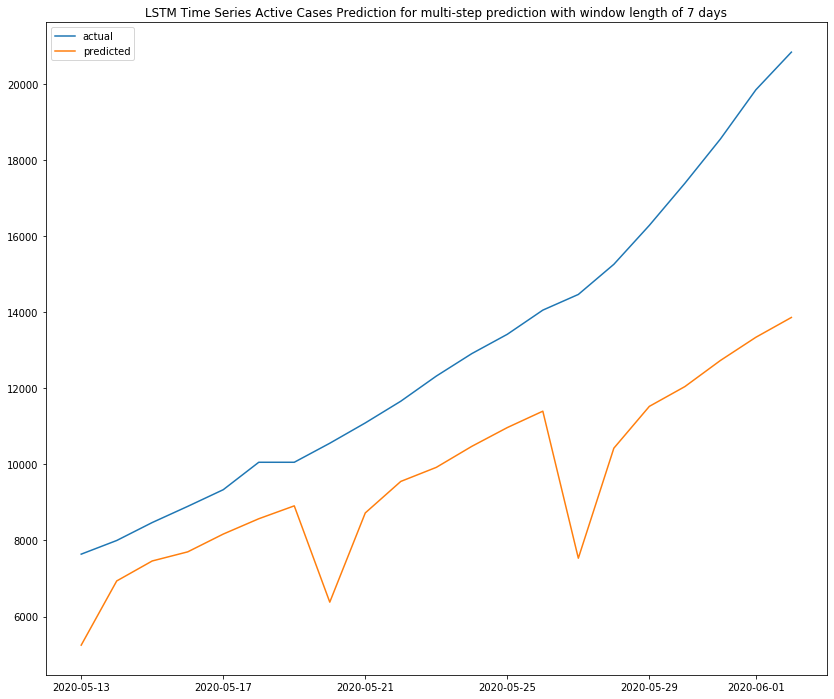

Test RMSE: 3865.841


In [54]:
test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
actual = actual.reshape((actual.shape[0]*actual.shape[1], 1))

predicted = predicted.reshape((predicted.shape[0]*predicted.shape[1], 1))


inv_pred = np.concatenate((predicted, test[:, 1:]), axis=1)
inv_y = np.concatenate((actual, test[:, 1:]), axis=1)

inv_pred = scaler.inverse_transform(inv_pred)
inv_pred = inv_pred[:, 0]

inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]


#Plotting
ind_dend=np.shape(test)[0]
ind_dstart =  np.shape(train)[0] *np.shape(train)[1]
dateStart = daterange[ind_dstart]
dateEnd = daterange[ind_dstart+ind_dend]


pred_index= pd.date_range(start=dateStart, periods=ind_dend, freq='D')
inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_pred, pred_index)


plt.figure(figsize=(14, 12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title(ModelType +  ' Time Series Active Cases Prediction for multi-step prediction with window length of 7 days')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)

# Multi Step Bi-directional LSTM based Prediction for State Delhi

Actual Results (3, 7)
Predicted  Results (3, 7, 1)


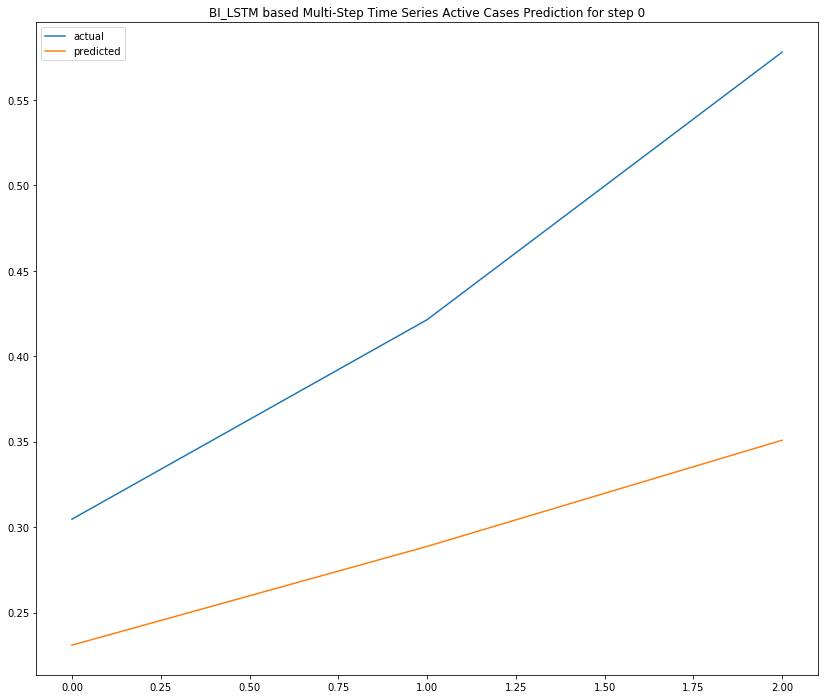

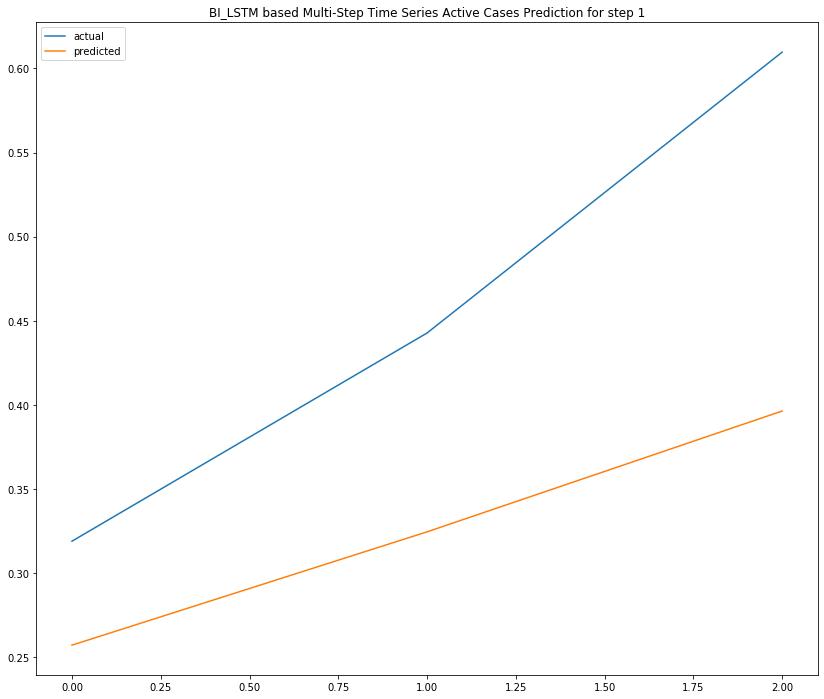

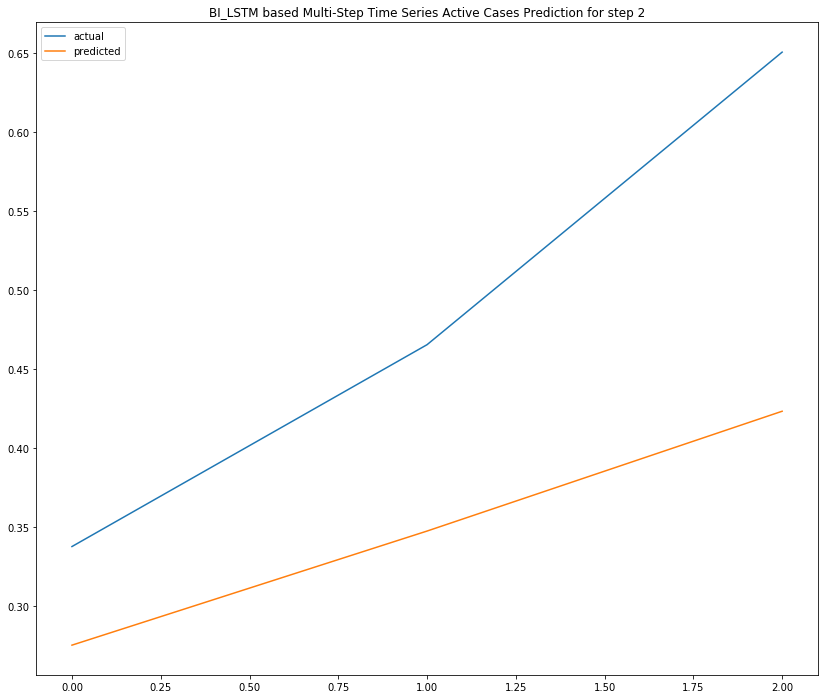

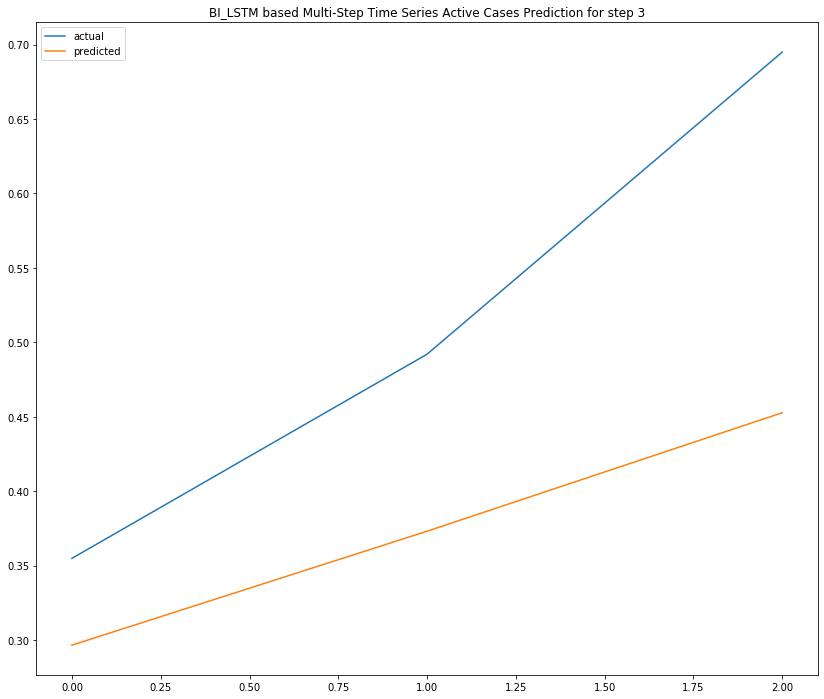

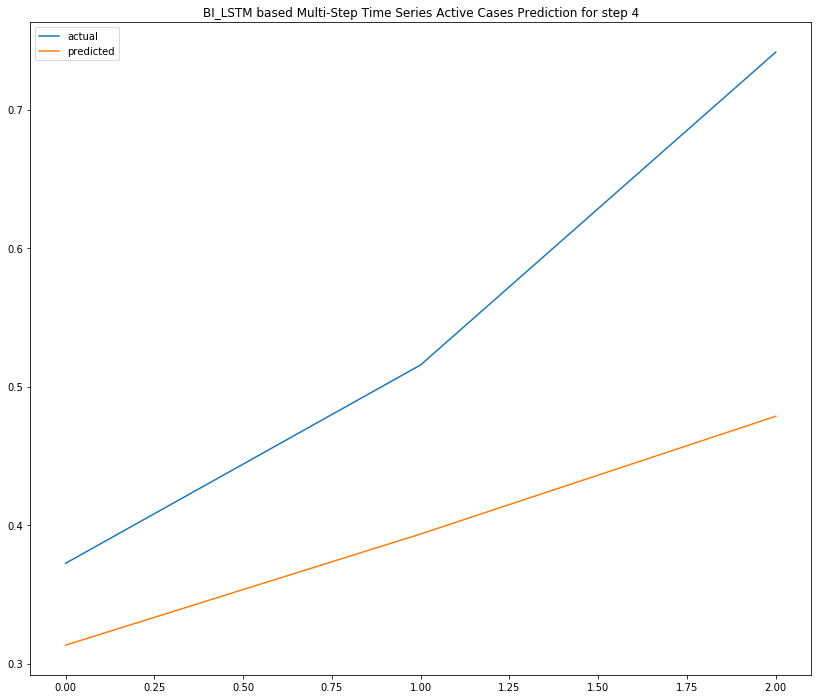

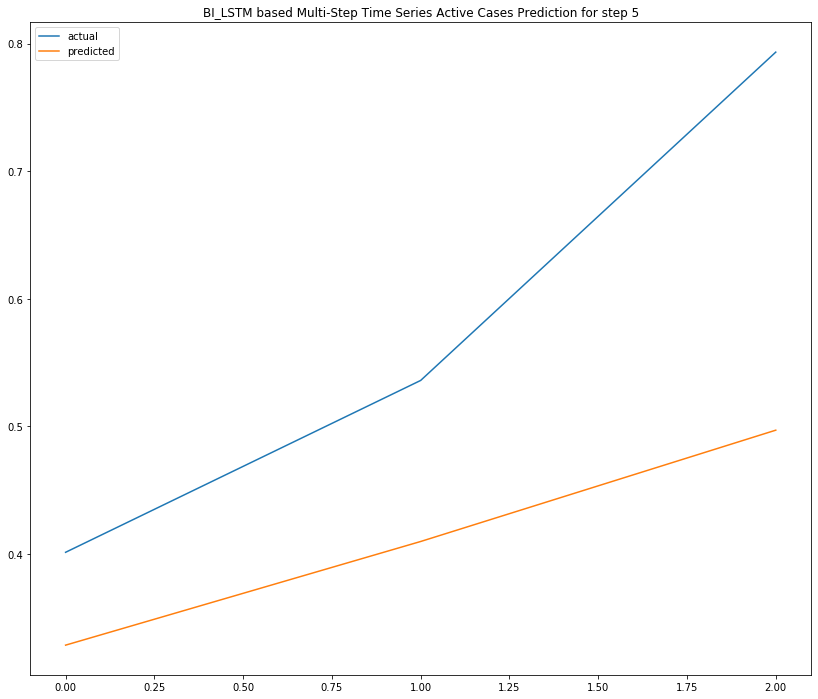

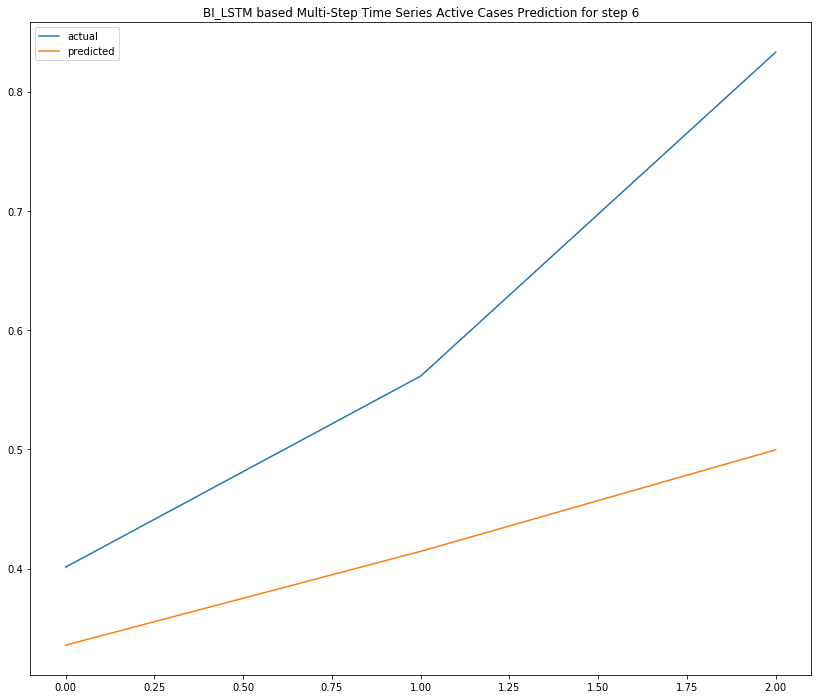

BI_LSTM: [0.171] 0.2, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2


In [57]:
df_state_all = pd.read_csv('all_states/all.csv')
df_state_all = df_state_all.drop(columns=['Latitude', 'Longitude', 'index'])
stateName = unique_states[8]



dataset = df_state_all[df_state_all['Name of State / UT'] == unique_states[8]]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-25') & (dataset['Date'] <= '2020-06-06')]

daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]

dataset = dataset.drop(columns=['Unnamed: 0', 'Date', 'source1', 'state', 'Name of State / UT', 'tagpeopleinquarantine', 'tagtotaltested'])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

# split into train and test
train, test = split_dataset(scaled_dataset)


# evaluate model and get scores
n_input =7
score, scores, actual, predicted = evaluate_model(train, test, n_input)
summarize_scores(ModelType, score, scores)

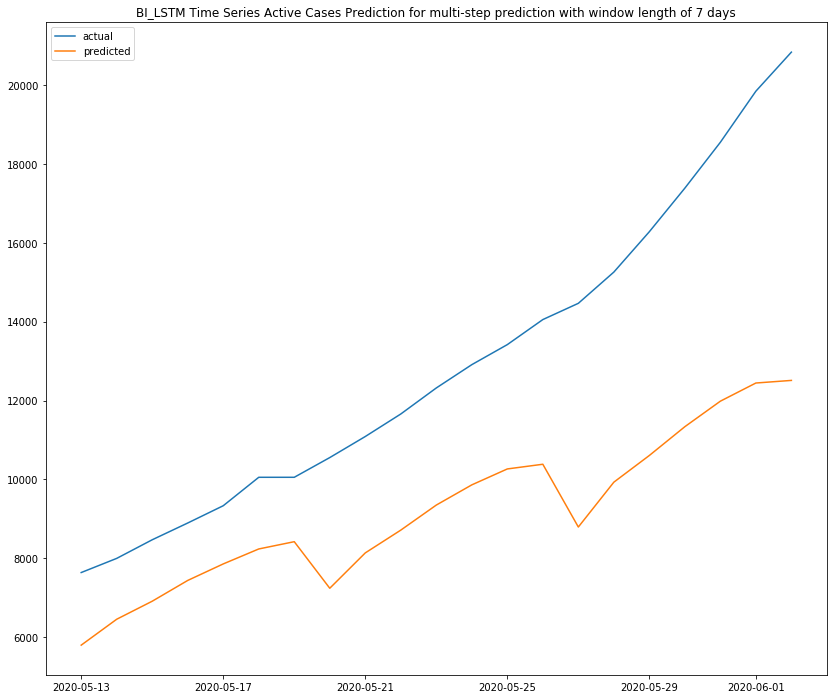

Test RMSE: 4280.499


In [58]:
test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
actual = actual.reshape((actual.shape[0]*actual.shape[1], 1))

predicted = predicted.reshape((predicted.shape[0]*predicted.shape[1], 1))
inv_pred = np.concatenate((predicted, test[:, 1:]), axis=1)
inv_y = np.concatenate((actual, test[:, 1:]), axis=1)


inv_pred = scaler.inverse_transform(inv_pred)
inv_pred = inv_pred[:, 0]

inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]


#For plotting
ind_dend=np.shape(test)[0]
ind_dstart =  np.shape(train)[0] *np.shape(train)[1]
dateStart = daterange[ind_dstart]
dateEnd = daterange[ind_dstart+ind_dend]

pred_index= pd.date_range(start=dateStart, periods=ind_dend, freq='D')
inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_pred, pred_index)


plt.figure(figsize=(14, 12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title(ModelType +  ' Time Series Active Cases Prediction for multi-step prediction with window length of 7 days')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)

# Multi Step CNN based Prediction for State Delhi

(73, 30)
Index(['Total Confirmed cases', 'Death', 'Cured/Discharged/Migrated',
       'coronaenquirycalls', 'cumulativepeopleinquarantine', 'negative',
       'numcallsstatehelpline', 'numicubeds', 'numisolationbeds',
       'numventilators', 'populationncp2019projection', 'positive',
       'testpositivityrate', 'testspermillion', 'testsperpositivecase',
       'testsperthousand', 'totaln95masks', 'totalpeoplecurrentlyinquarantine',
       'totalpeoplereleasedfromquarantine', 'totalppe', 'totaltested',
       'unconfirmed', 'Active Cases'],
      dtype='object')


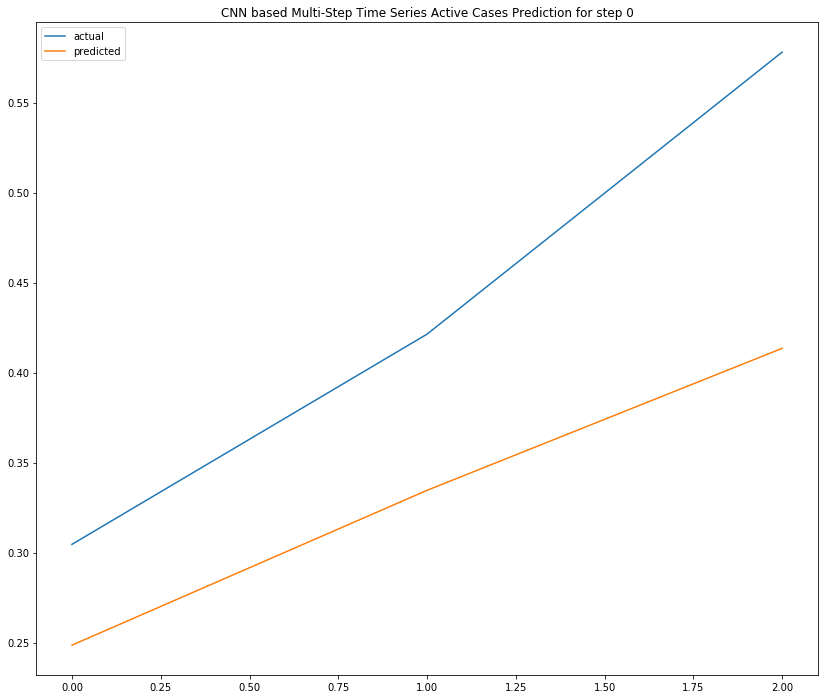

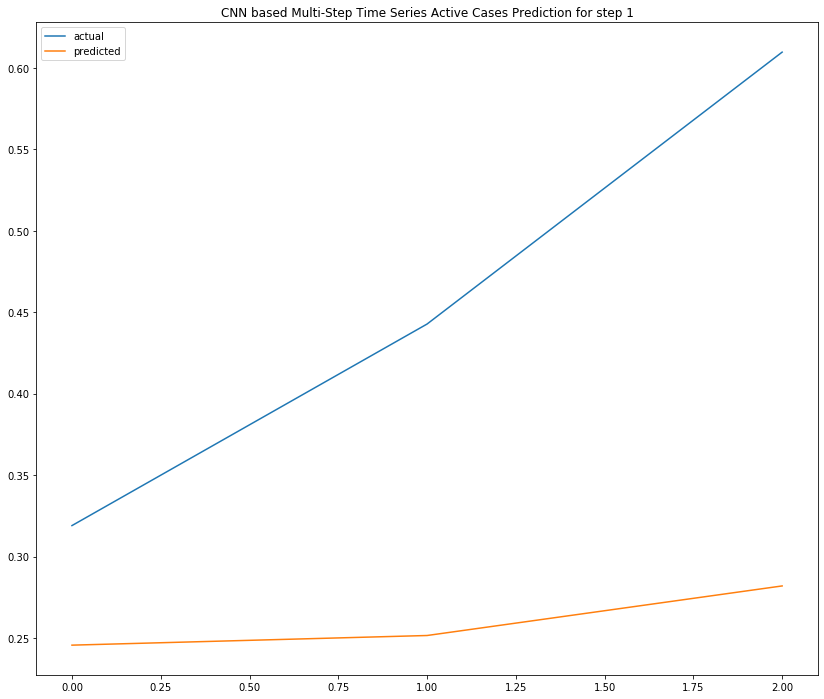

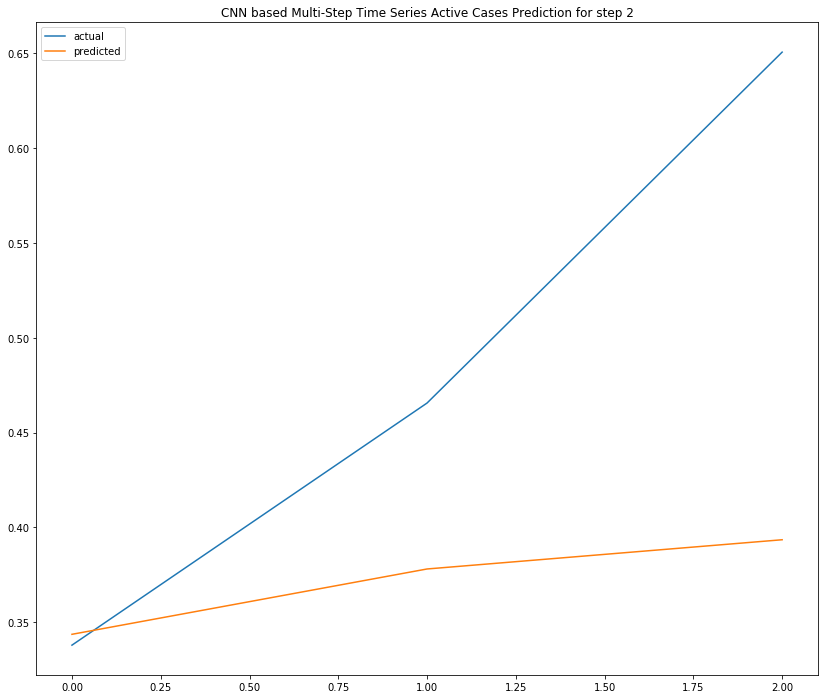

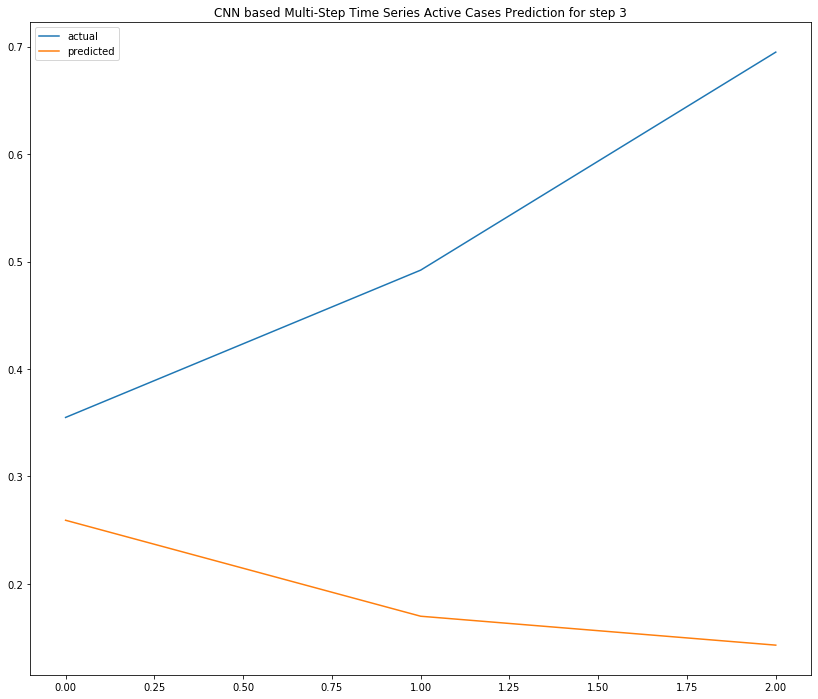

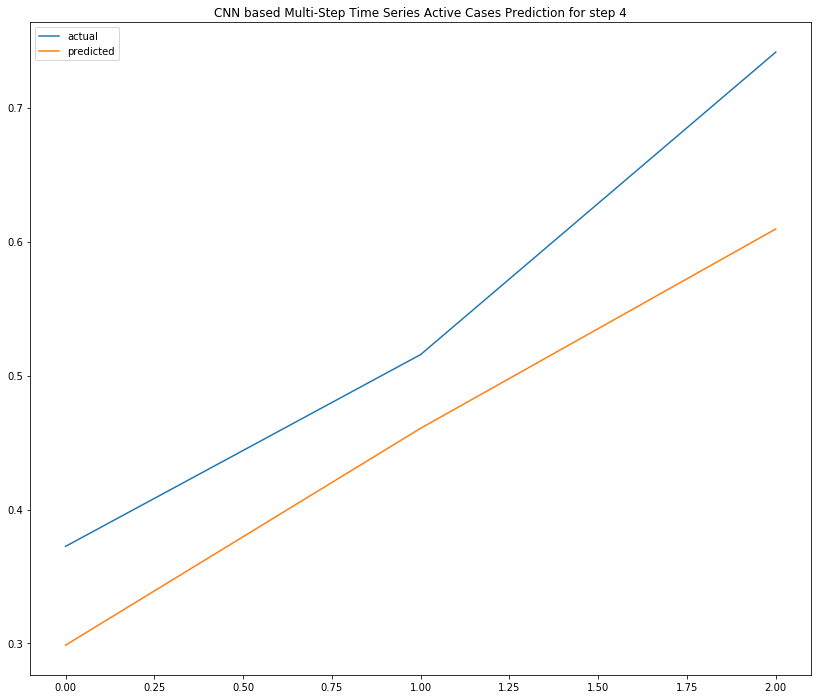

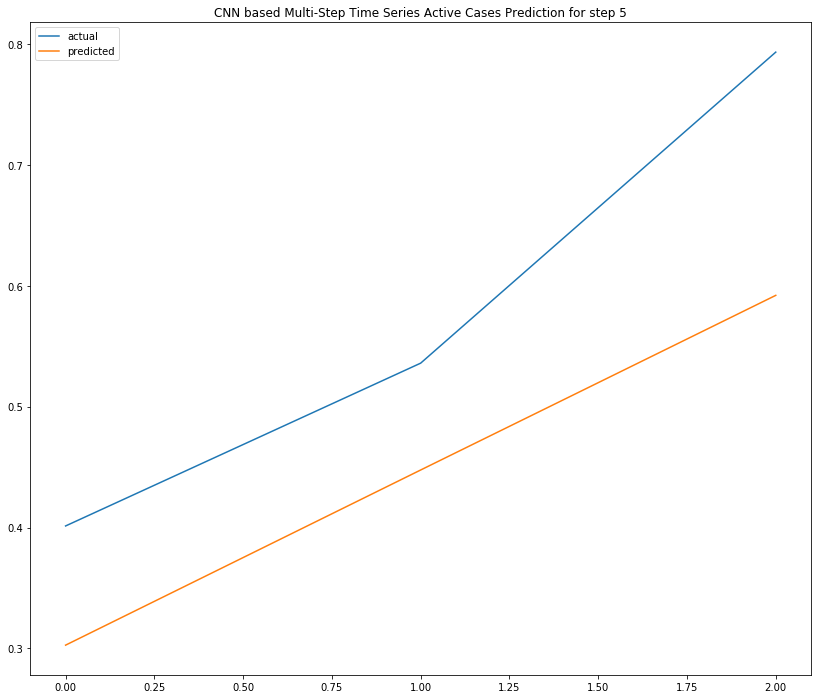

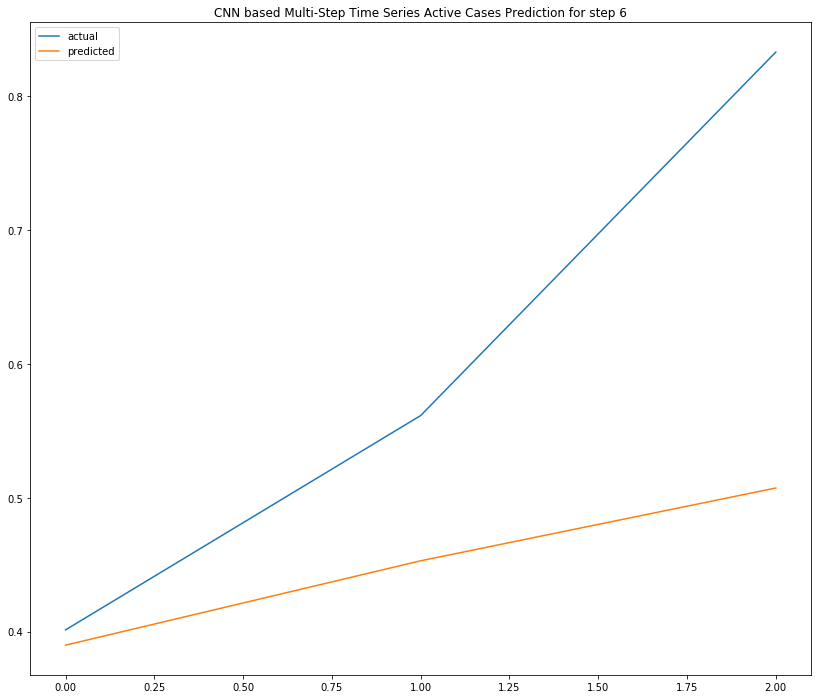

CNN: [0.205] 0.1, 0.2, 0.2, 0.4, 0.1, 0.1, 0.2


In [86]:
df_state_all = pd.read_csv('all_states/all.csv')
df_state_all = df_state_all.drop(columns=['Latitude', 'Longitude', 'index'])
stateName = unique_states[8]



dataset = df_state_all[df_state_all['Name of State / UT'] == unique_states[8]]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-25') & (dataset['Date'] <= '2020-06-06')]

print(np.shape(dataset))
daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]

dataset = dataset.drop(columns=['Unnamed: 0', 'Date', 'source1', 'state', 'Name of State / UT', 'tagpeopleinquarantine', 'tagtotaltested'])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

# split into train and test
train, test = split_dataset(scaled_dataset)
print(dataset.columns)


n_input =14
score, scores, actual, predicted = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores(ModelType, score, scores)

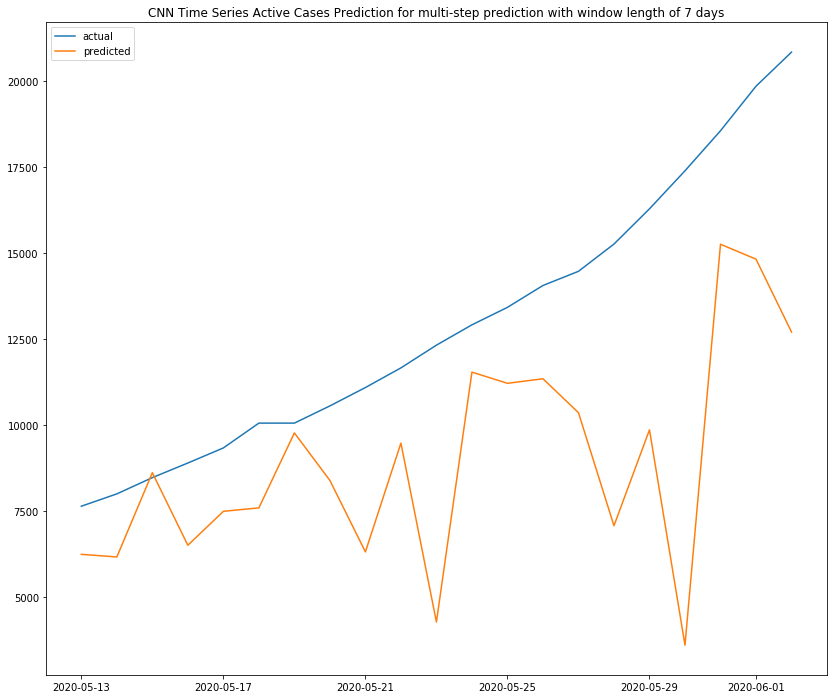

Test RMSE: 5113.262


In [87]:
test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
actual = actual.reshape((actual.shape[0]*actual.shape[1], 1))
predicted = predicted.reshape((predicted.shape[0]*predicted.shape[1], 1))


inv_pred = np.concatenate((predicted, test[:, 1:]), axis=1)
inv_y = np.concatenate((actual, test[:, 1:]), axis=1)


inv_pred = scaler.inverse_transform(inv_pred)
inv_pred = inv_pred[:, 0]

inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]



#For plotting
ind_dend=np.shape(test)[0]
ind_dstart =  np.shape(train)[0] *np.shape(train)[1]
dateStart = daterange[ind_dstart]
dateEnd = daterange[ind_dstart+ind_dend]

pred_index= pd.date_range(start=dateStart, periods=ind_dend, freq='D')


inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_pred, pred_index)


plt.figure(figsize=(14, 12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title(ModelType +  ' Time Series Active Cases Prediction for multi-step prediction with window length of 7 days')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)

# Multi Step CNN +LSTM based Prediction for State Delhi

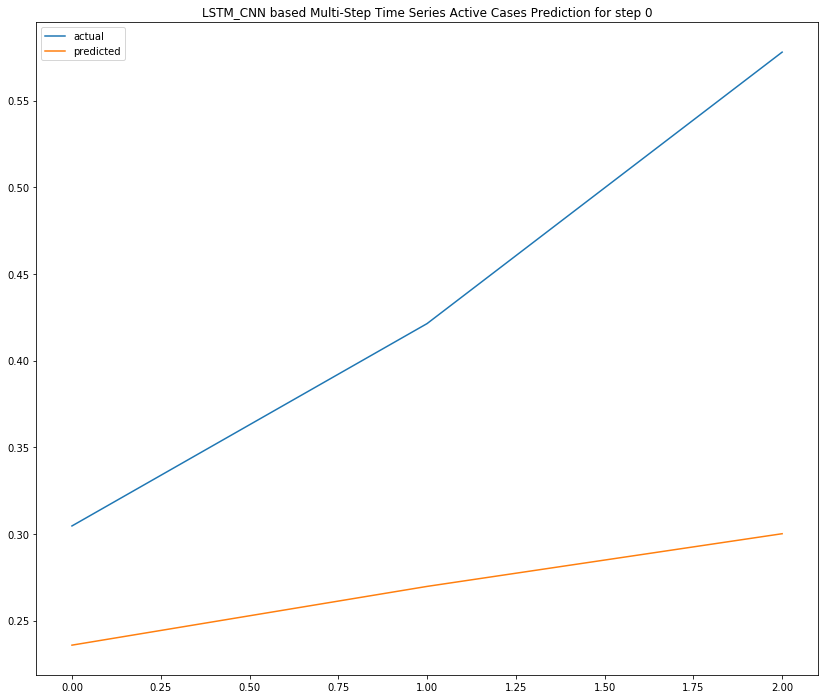

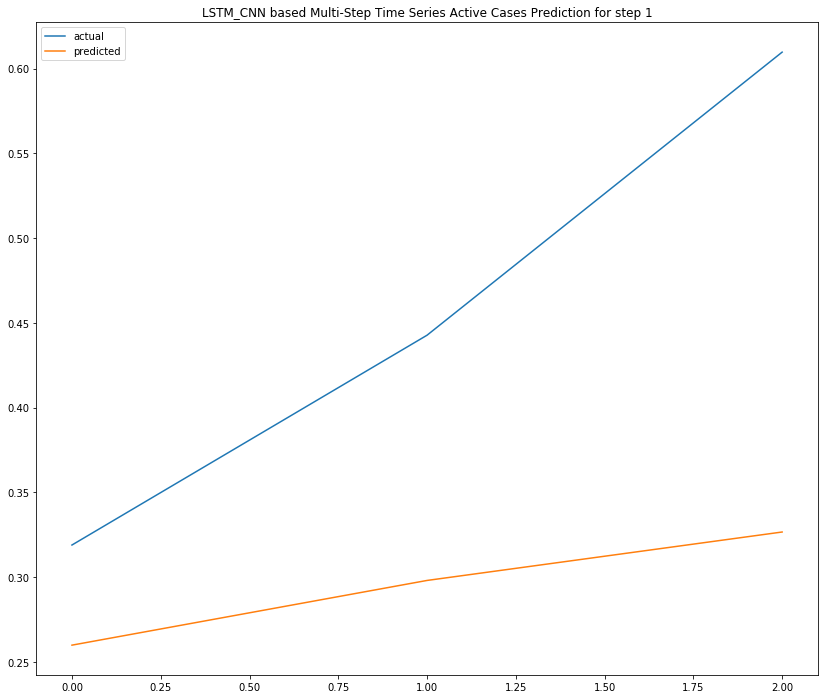

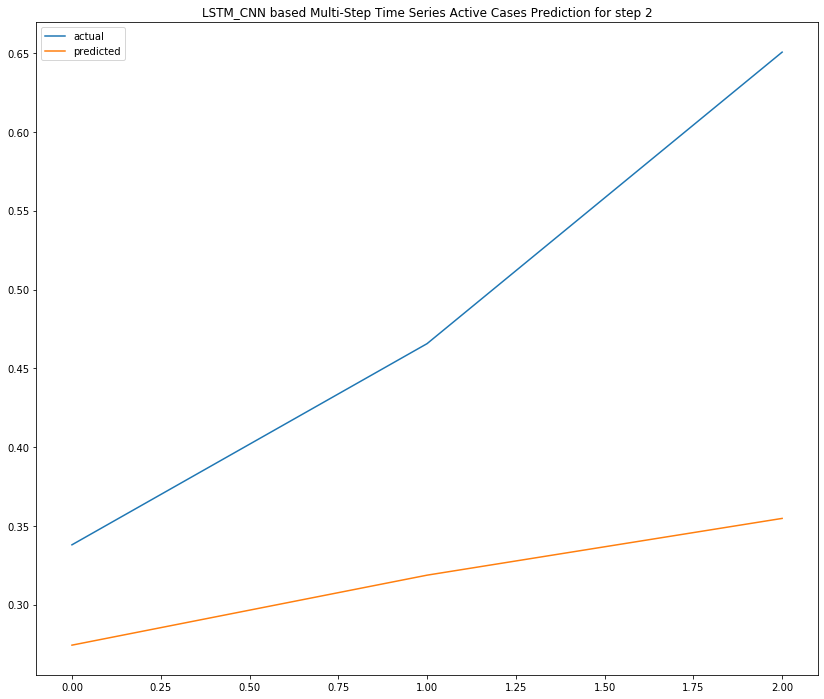

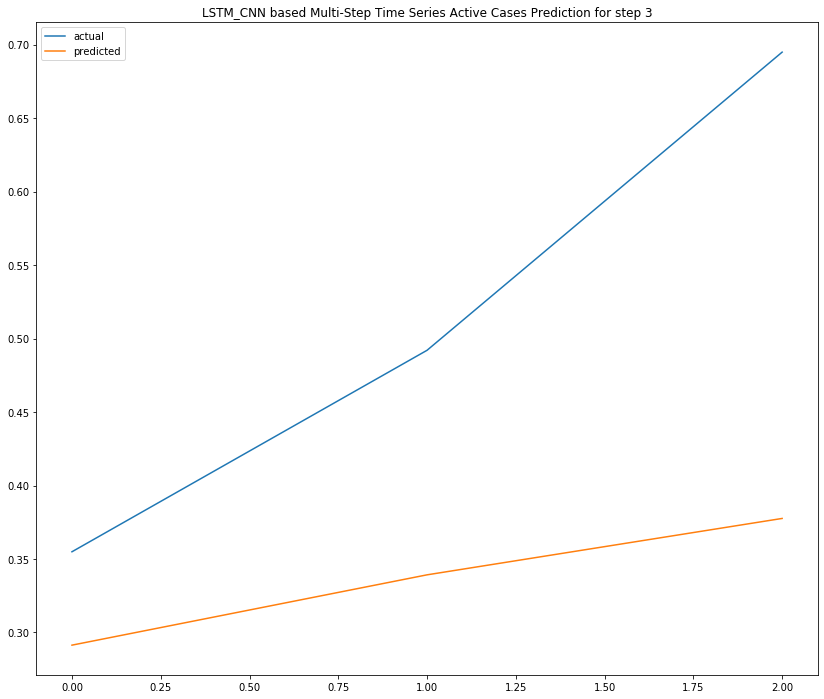

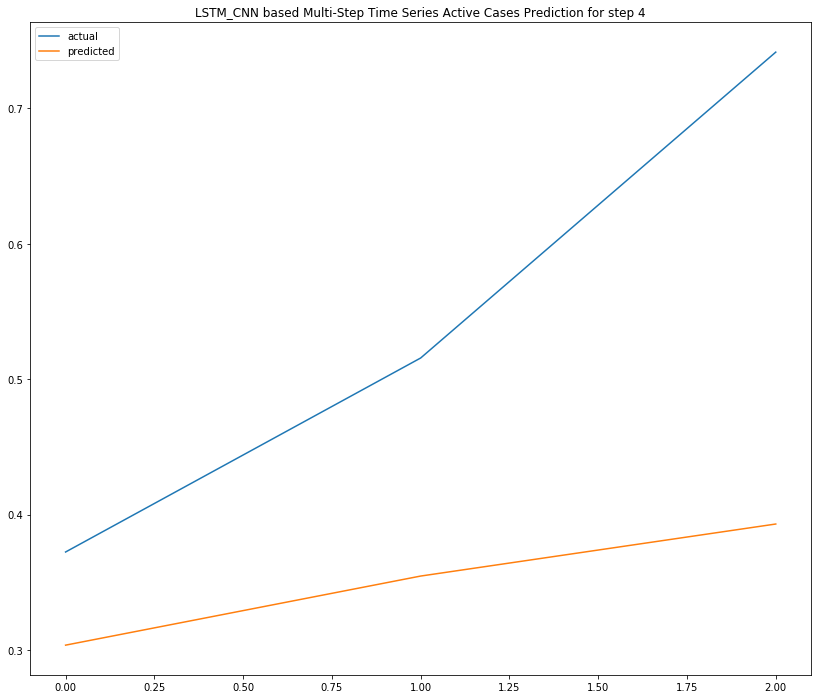

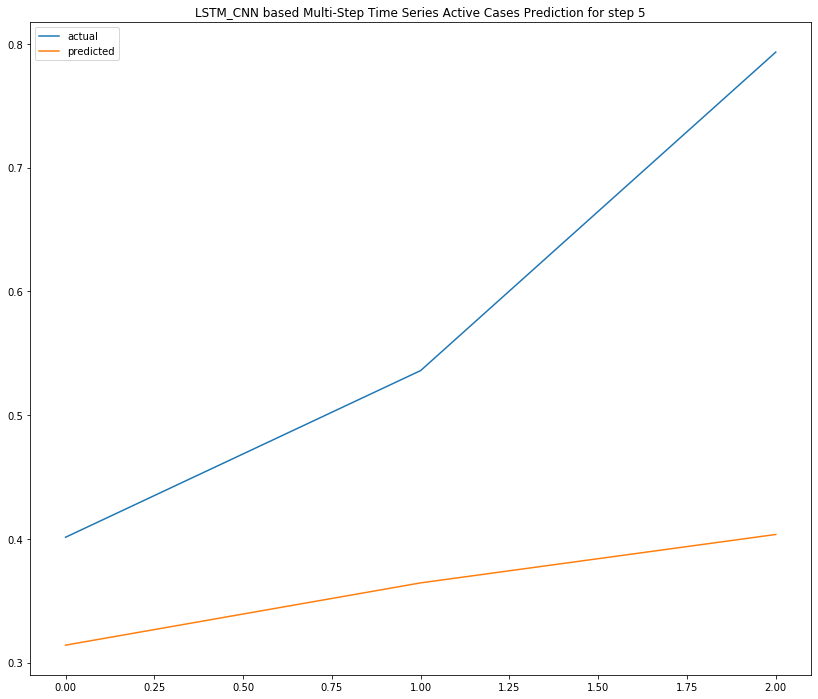

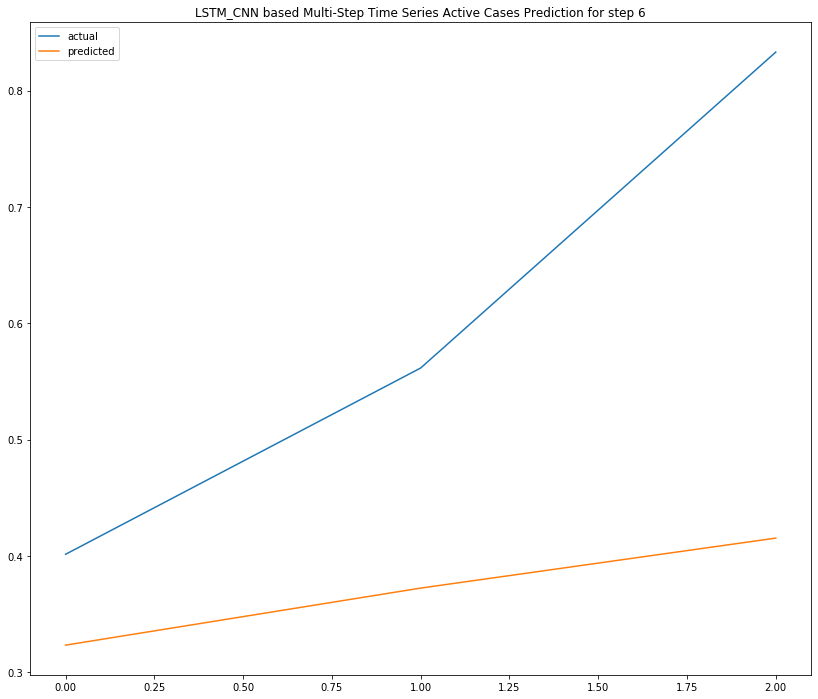

LSTM_CNN: [0.219] 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3


In [92]:
df_state_all = pd.read_csv('all_states/all.csv')
df_state_all = df_state_all.drop(columns=['Latitude', 'Longitude', 'index'])
stateName = unique_states[8]



dataset = df_state_all[df_state_all['Name of State / UT'] == unique_states[8]]
dataset = dataset.sort_values(by='Date', ascending=True)

dataset = dataset[(dataset['Date'] >= '2020-03-25') & (dataset['Date'] <= '2020-06-06')]

daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]


dataset = dataset.drop(columns=['Unnamed: 0', 'Date', 'source1', 'state', 'Name of State / UT', 'tagpeopleinquarantine', 'tagtotaltested'])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

# split into train and test
train, test = split_dataset(scaled_dataset)

# evaluate model and get scores
n_input =7
score, scores, actual, predicted = evaluate_model(train, test, n_input)
summarize_scores(ModelType, score, scores)

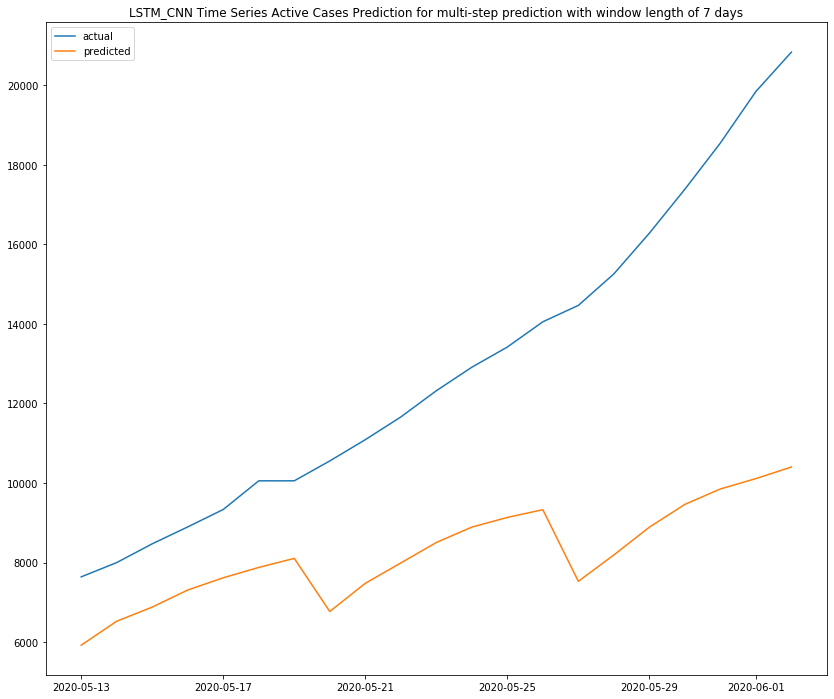

Test RMSE: 5471.851


In [93]:
test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))

actual = actual.reshape((actual.shape[0]*actual.shape[1], 1))
predicted = predicted.reshape((predicted.shape[0]*predicted.shape[1], 1))

inv_pred = np.concatenate((predicted, test[:, 1:]), axis=1)
inv_y = np.concatenate((actual, test[:, 1:]), axis=1)

inv_pred = scaler.inverse_transform(inv_pred)
inv_pred = inv_pred[:, 0]

inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]


#For plotting
ind_dend=np.shape(test)[0]
ind_dstart =  np.shape(train)[0] *np.shape(train)[1]
dateStart = daterange[ind_dstart]
dateEnd = daterange[ind_dstart+ind_dend]

pred_index= pd.date_range(start=dateStart, periods=ind_dend, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_pred, pred_index)


plt.figure(figsize=(14, 12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title(ModelType +  ' Time Series Active Cases Prediction for multi-step prediction with window length of 7 days')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)

# Uni-Variate Multi Step Conv2D + LSTM based Prediction for State Delhi

### First we try Conv2D with LSTM for univariate data where we predict number of Active Caases, before trying out Multi-variaate analysis

The trained data (X) is reshapedinto subsequences of  [samples, time steps, rows =1, cols, channels], whereas the predicted variable is reshaped to  [samples, timesteps, features]. 
The model is run for 750 epochs , with batch size 16 

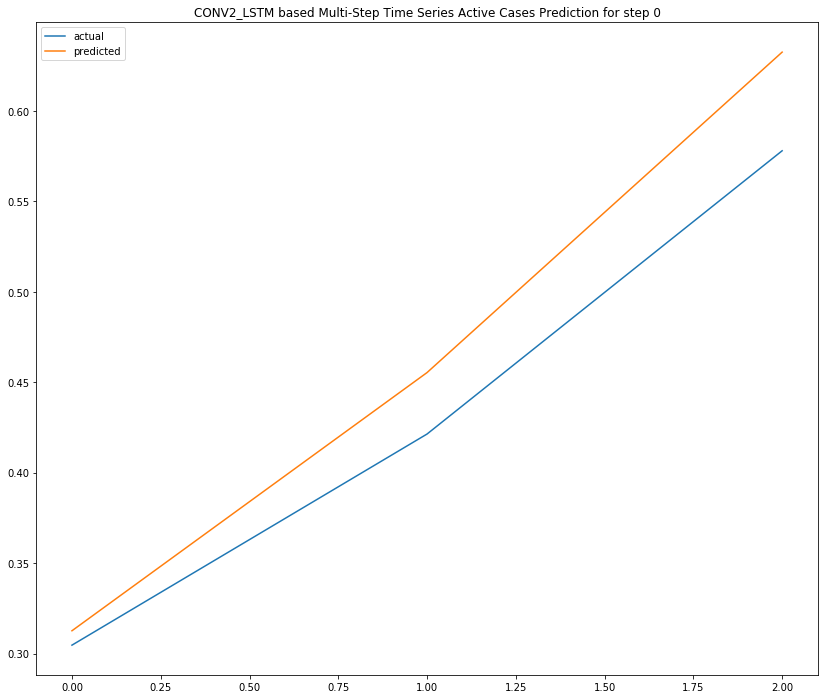

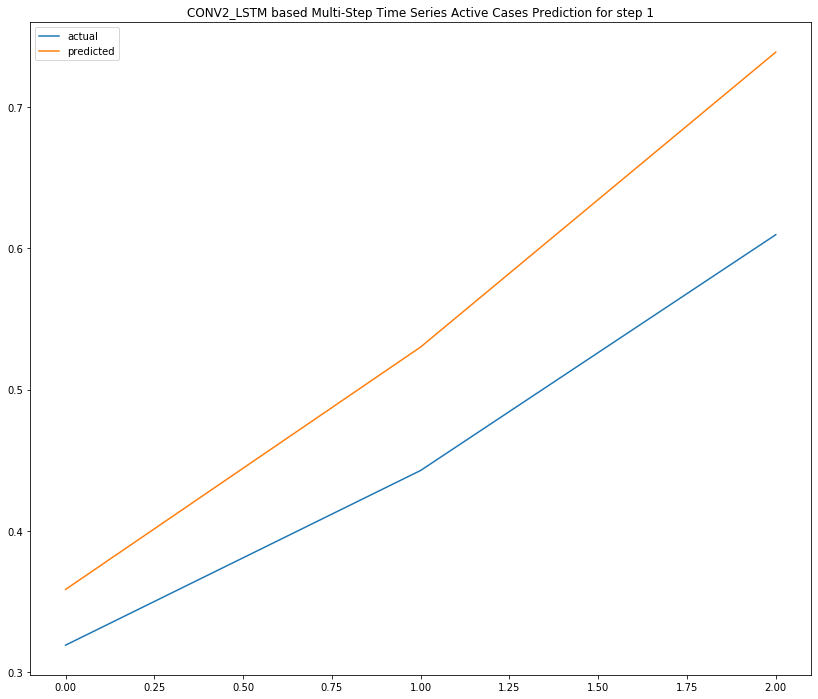

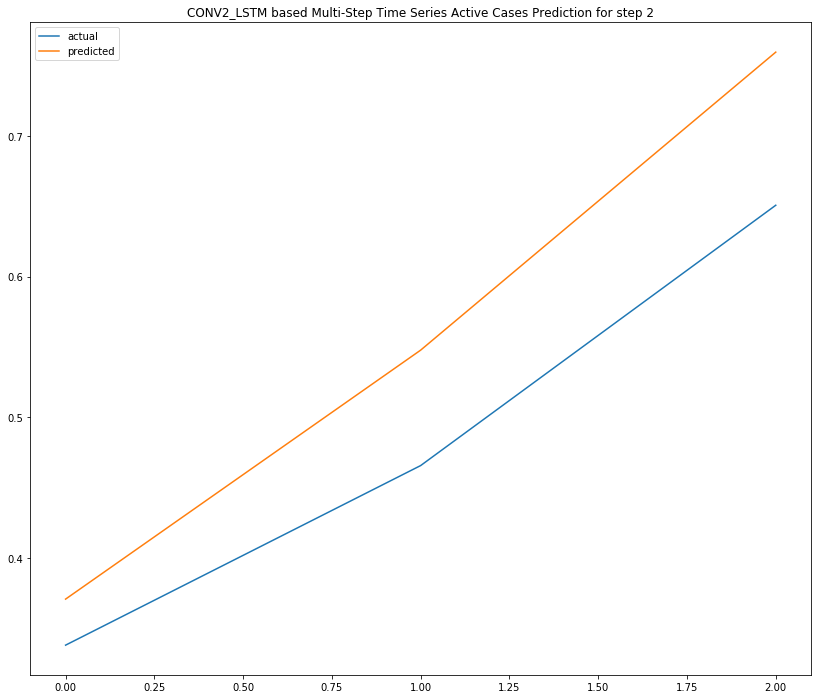

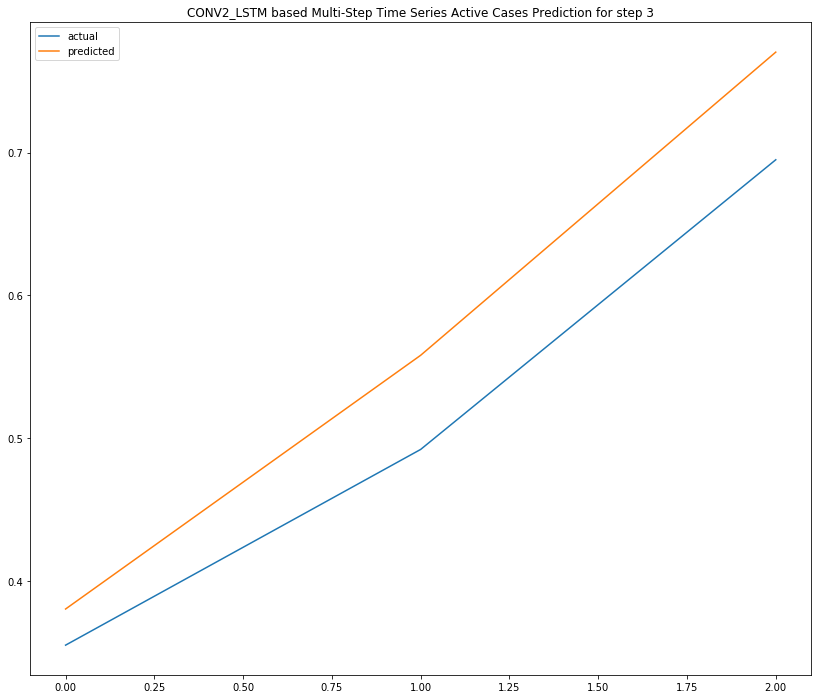

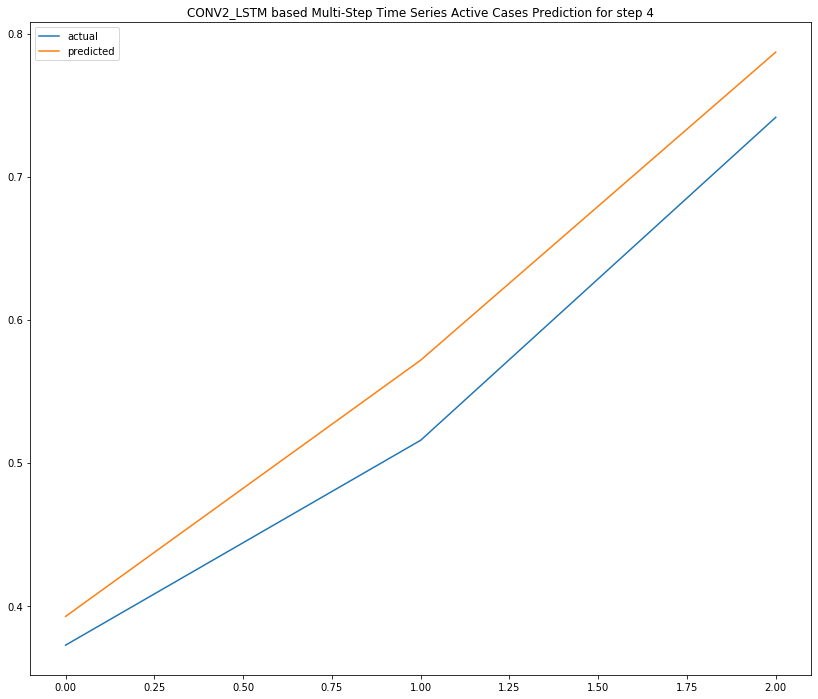

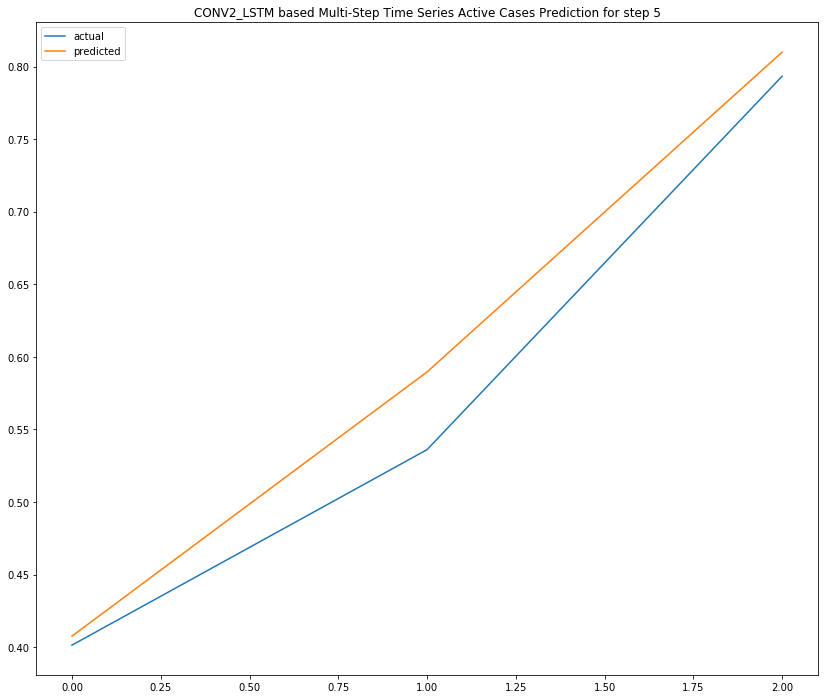

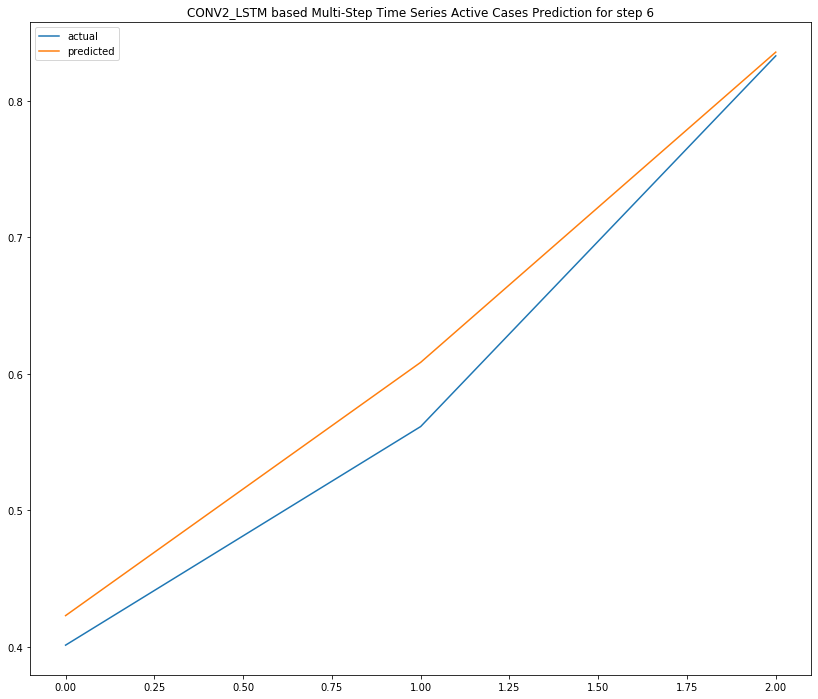

CONV2_LSTM: [0.059] 0.0, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0


In [107]:
def build_model_cnn_lstm_2d(train, n_steps, n_length, n_input):
    
    train_x, train_y = to_supervised_2cnn_lstm(train, n_input)

    verbose, epochs, batch_size = 0, 750, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')

    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


def to_supervised_2cnn_lstm(train, n_input, n_out=7):
    
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # Iterate over history one time step at a time
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        #Checking for sufiicient size of the data
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        
        in_start += 1
    return array(X), array(y)
                      
# making forecast for next week
def forecast_2cnn_lstm(model, history, n_steps, n_length, n_input):
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat

def evaluate_model_2cnn_lstm(train, test, n_steps, n_length, n_input):
    
    model = build_model_cnn_lstm_2d(train, n_steps, n_length, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast_2cnn_lstm(model, history, n_steps, n_length, n_input)
        predictions.append(yhat_sequence)
        # Same as before the predicted outcome is added to history for predicting the next week
        history.append(test[i, :])
    
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, test[:, :, 0], predictions


df_state_all = pd.read_csv('all_states/all.csv')
df_state_all = df_state_all.drop(columns=['Latitude', 'Longitude', 'index'])
stateName = unique_states[8]


dataset = df_state_all[df_state_all['Name of State / UT'] == unique_states[8]]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-25') & (dataset['Date'] <= '2020-06-06')]


daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]
dataset = dataset.drop(columns=['Unnamed: 0', 'Date', 'source1', 'state', 'Name of State / UT', 'tagpeopleinquarantine', 'tagtotaltested'])
n = np.shape(dataset)[0]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

# split into train and test
train, test = split_dataset(scaled_dataset)

# define the number of subsequences and the length of subsequences
n_steps, n_length = 2, 7
n_input = n_length * n_steps
score, scores, actual, predicted = evaluate_model_2cnn_lstm(train, test, n_steps, n_length, n_input)
summarize_scores(ModelType, score, scores)

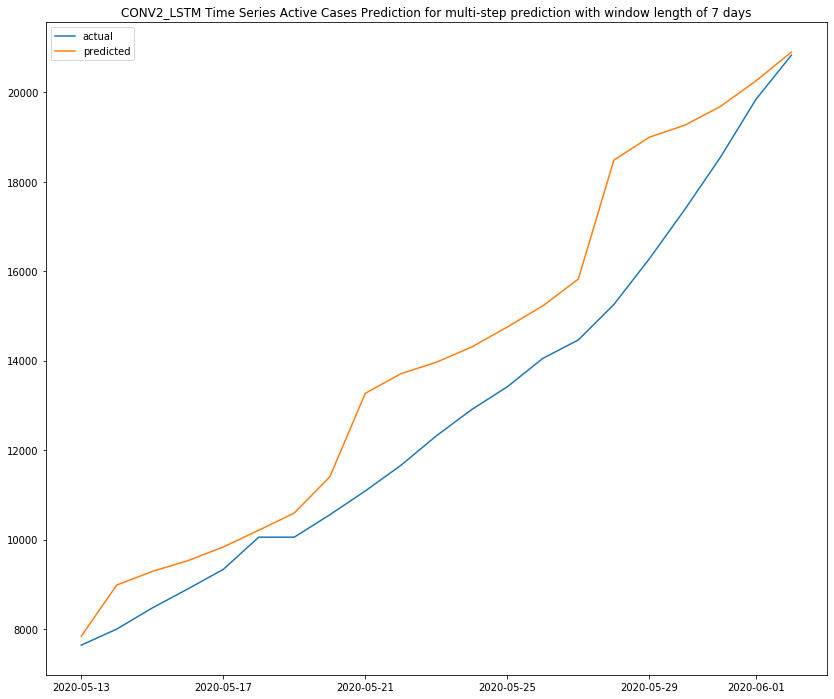

Test RMSE: 1461.551


In [108]:
test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
actual = actual.reshape((actual.shape[0]*actual.shape[1], 1))
predicted = predicted.reshape((predicted.shape[0]*predicted.shape[1], 1))


inv_pred = np.concatenate((predicted, test[:, 1:]), axis=1)
inv_y = np.concatenate((actual, test[:, 1:]), axis=1)
inv_pred = scaler.inverse_transform(inv_pred)
inv_pred = inv_pred[:, 0]

inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]


#For plotting
ind_dend=np.shape(test)[0]
ind_dstart =  np.shape(train)[0] *np.shape(train)[1]
dateStart = daterange[ind_dstart]
dateEnd = daterange[ind_dstart+ind_dend]

pred_index= pd.date_range(start=dateStart, periods=ind_dend, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_pred, pred_index)


plt.figure(figsize=(14, 12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title(ModelType +  ' Time Series Active Cases Prediction for multi-step prediction with window length of 7 days')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)

# Multi-Variate Multi-Step Conv2D + LSTM based Prediction for State Delhi

### CONV_LSTM2D Model

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_8 (ConvLSTM2D)  (None, 1, 5, 64)          67072     
_________________________________________________________________
flatten_12 (Flatten)         (None, 320)               0         
_________________________________________________________________
repeat_vector_13 (RepeatVect (None, 7, 320)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 7, 200)            416800    
_________________________________________________________________
time_distributed_26 (TimeDis (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_27 (TimeDis (None, 7, 1)              101       
Total params: 504,073
Trainable params: 504,073
Non-trainable params: 0
_______________________________________________

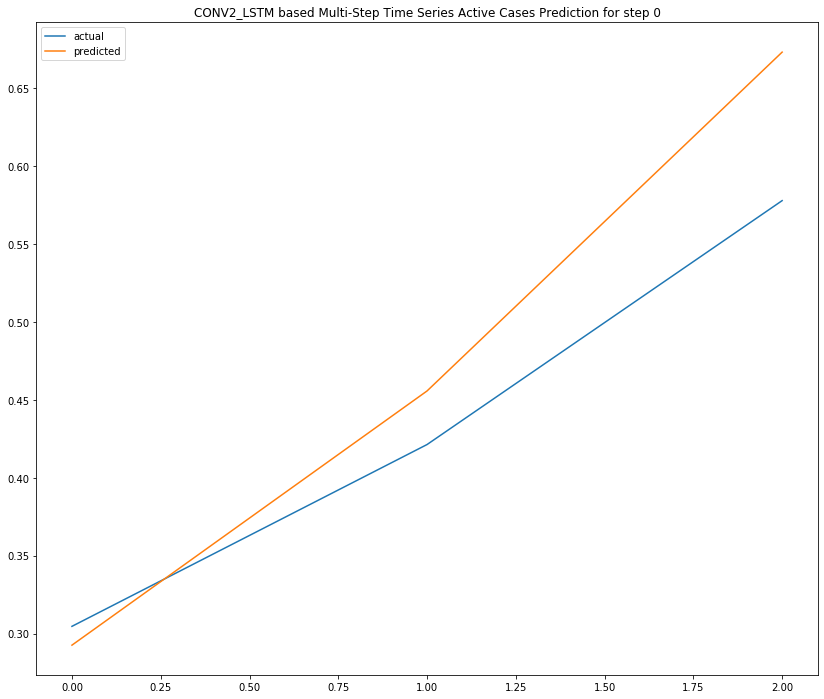

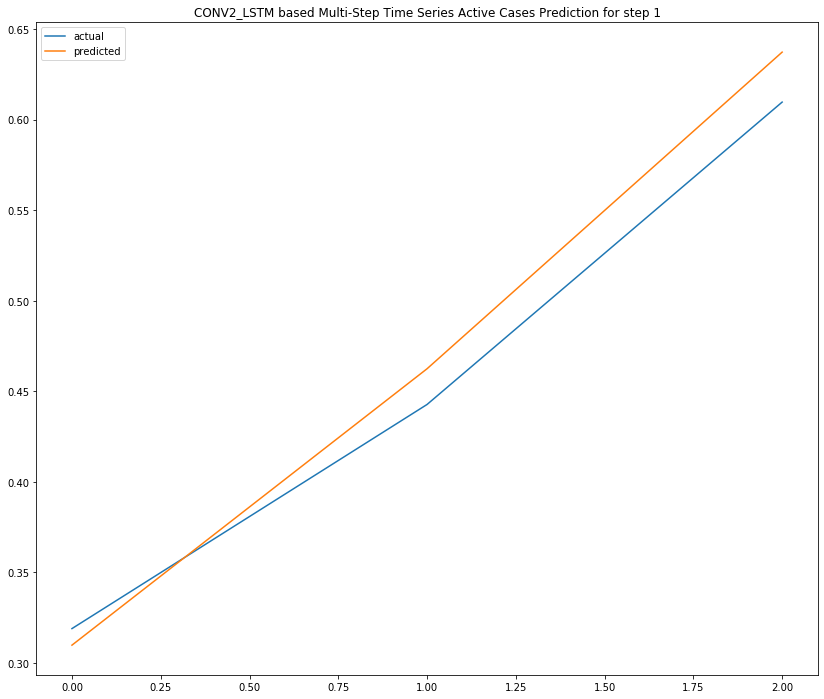

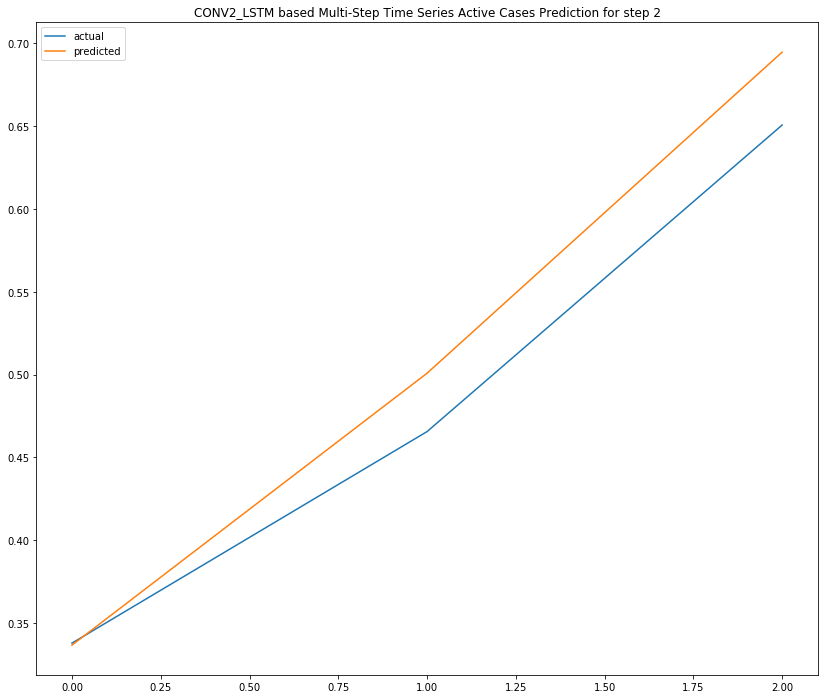

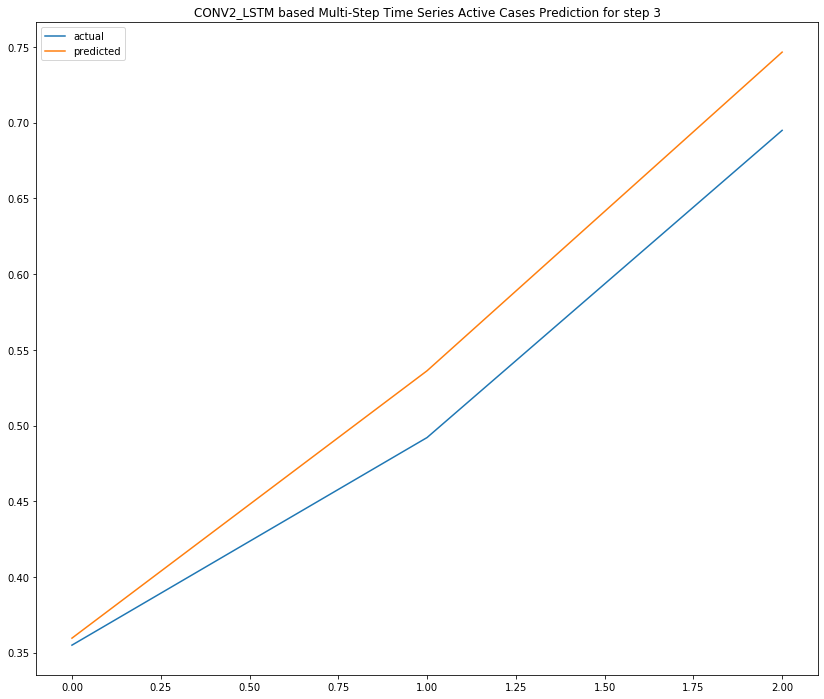

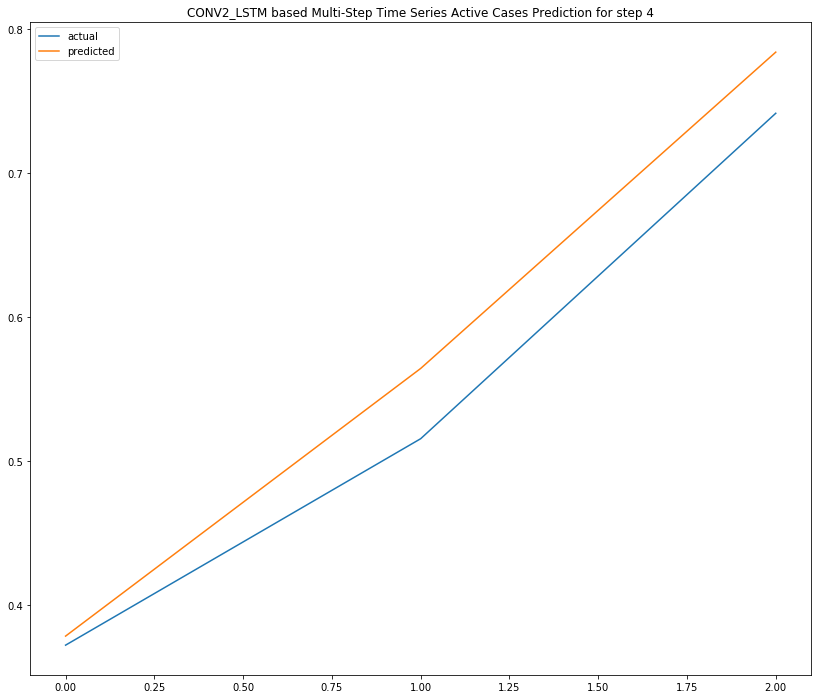

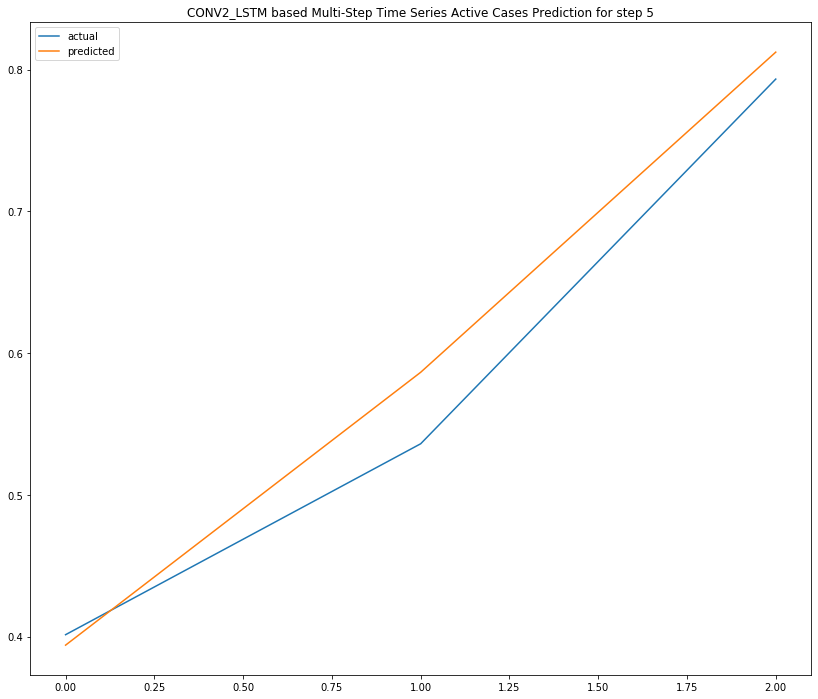

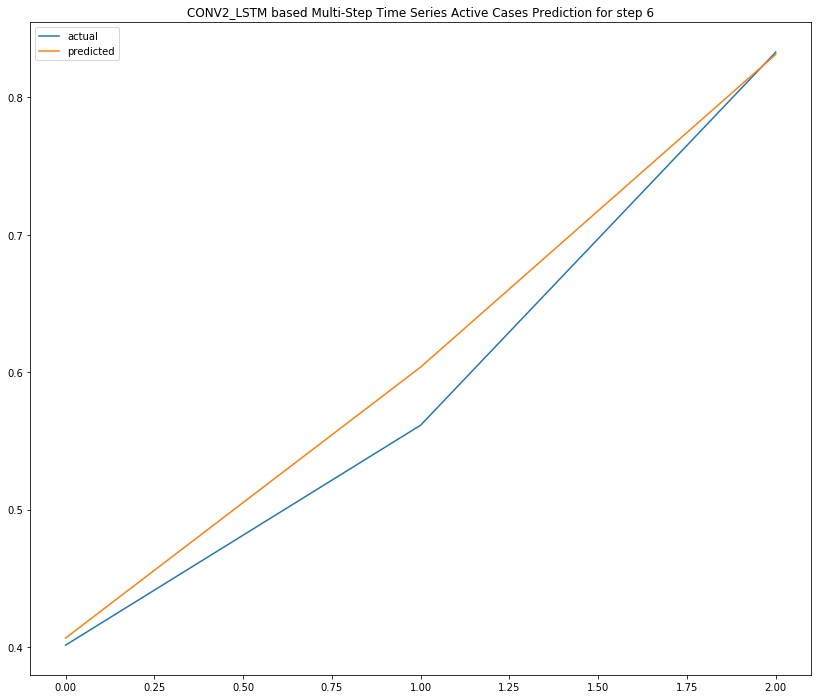

CONV2_LSTM: [0.037] 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0


In [130]:
def build_multi_model_cnn_lstm_2d(train, n_steps, n_length, n_input):
    
    # prepare data
    train_x, train_y = to__multi_supervised_2cnn_lstm(train, n_input)
    verbose, epochs, batch_size = 0, 750, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1]))

    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    print(model.summary())
    return model


# Input Output Conversion on Historic Data
def to_multi_supervised_2cnn_lstm(train, n_input, n_out=7):
    
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # Iterate over historic data per sstep/time
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
    
        if out_end <= len(data):
            x_input = data[in_start:in_end, :]
            x_input = x_input.reshape((len(x_input), x_input.shape[1]))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1
        return array(X), array(y)
                      
# prediction for week
def forecast_multi_2cnn_lstm(model, history, n_steps, n_length, n_input):
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [samples, time steps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, data.shape[1]))  #train_x.shape[0], n_steps, 1, n_length, n_features
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat

# model evaluation
def evaluate_multi_model_2cnn_lstm(train, test, n_steps, n_length, n_input):
    model = build_multi_model_cnn_lstm_2d(train, n_steps, n_length, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        yhat_sequence = forecast__multi_2cnn_lstm(model, history, n_steps, n_length, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, test[:, :, 0], predictions


df_state_all = pd.read_csv('all_states/all.csv')
df_state_all = df_state_all.drop(columns=['Latitude', 'Longitude', 'index'])
stateName = unique_states[8]


dataset = df_state_all[df_state_all['Name of State / UT'] == unique_states[8]]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-25') & (dataset['Date'] <= '2020-06-06')]

daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]



dataset = dataset.drop(columns=['Unnamed: 0', 'Date', 'source1', 'state', 'Name of State / UT', 'tagpeopleinquarantine', 'tagtotaltested'])
n = np.shape(dataset)[0]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

# split into train and test
train, test = split_dataset(scaled_dataset)

# Seeting Number of subsequences and the length of subsequences
n_steps, n_length = 1, 7
n_input = n_length * n_steps
score, scores, actual, predicted = evaluate_multi_model_2cnn_lstm(train, test, n_steps, n_length, n_input)
summarize_scores(ModelType, score, scores)

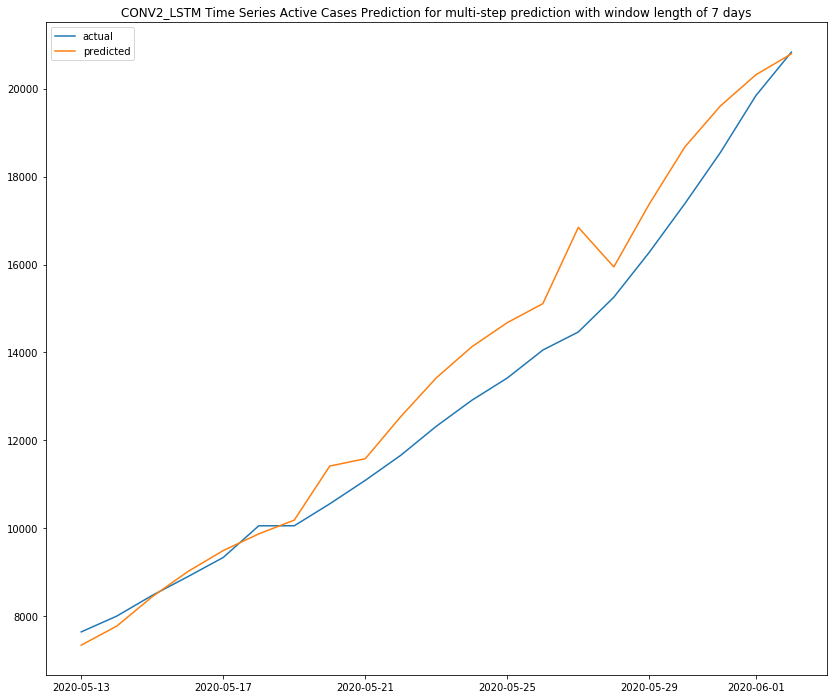

Test RMSE: 919.375


In [131]:
test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
actual = actual.reshape((actual.shape[0]*actual.shape[1], 1))
predicted = predicted.reshape((predicted.shape[0]*predicted.shape[1], 1))

inv_pred = np.concatenate((predicted, test[:, 1:]), axis=1)
inv_y = np.concatenate((actual, test[:, 1:]), axis=1)

inv_pred = scaler.inverse_transform(inv_pred)
inv_pred = inv_pred[:, 0]

inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]


#For plotting
ind_dend=np.shape(test)[0]
ind_dstart =  np.shape(train)[0] *np.shape(train)[1]
dateStart = daterange[ind_dstart]
dateEnd = daterange[ind_dstart+ind_dend]

pred_index= pd.date_range(start=dateStart, periods=ind_dend, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_pred, pred_index)


plt.figure(figsize=(14, 12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title(ModelType +  ' Time Series Active Cases Prediction for multi-step prediction with window length of 7 days')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)